# Monitoring PyTorch experiments with Managed TensorBoard

In [1]:
import base64
import os
import json
import time
import numpy as np
import tensorflow as tf

import google.auth

from google.auth.credentials import Credentials
from google.auth.transport.requests import AuthorizedSession

from typing import List, Optional, Text, Tuple

## Setting the environment

In [2]:
CAIP_ENDPOINT = "us-central1-aiplatform.googleapis.com"
CAIP_REGION = "us-central1"
TENSORBOARD_NAME = "pytorch-tensorboard"
GCS_BUCKET = "gs://jk-mlops-dev-tensorboard-logs-us-central1"

## Creating a Managed TensorBoard instance

### Create an authorized session

In [3]:
credentials, project_id = google.auth.default()
authed_session = AuthorizedSession(credentials)

alpha_api_prefix = f'https://{CAIP_ENDPOINT}/v1alpha1/projects/{project_id}/locations/{CAIP_REGION}'
beta_api_prefix = f'https://{CAIP_ENDPOINT}/v1beta1/projects/{project_id}/locations/{CAIP_REGION}'

### Create a TensorBoard resource

In [20]:
api_url = f'{alpha_api_prefix}/tensorboards'

request_body = {
    "display_name": TENSORBOARD_NAME
}

response = authed_session.post(api_url, data=json.dumps(request_body))
response.json()

{'name': 'projects/895222332033/locations/us-central1/tensorboards/1989183660414205952/operations/3698055627419942912',
 'metadata': {'@type': 'type.googleapis.com/google.cloud.aiplatform.v1alpha1.CreateTensorboardOperationMetadata',
  'genericMetadata': {'createTime': '2020-12-01T05:20:26.567702Z',
   'updateTime': '2020-12-01T05:20:26.567702Z'}}}

### List all tensorboards with a set name

In [4]:
api_url = f'{alpha_api_prefix}/tensorboards?filter=display_name={TENSORBOARD_NAME}'

response = authed_session.get(api_url)
response.json()

{'tensorboards': [{'name': 'projects/895222332033/locations/us-central1/tensorboards/1989183660414205952',
   'displayName': 'pytorch-tensorboard',
   'createTime': '2020-12-01T05:20:26.567702Z',
   'updateTime': '2020-12-01T05:20:26.695088Z',
   'etag': 'AMEw9yNpLRrYUWkKMdRdmwbHPNk7f-p9pLFZxevE8IYFTauLfhFNB6OaztcXjMqQ18Ik'}]}

## Preparing a training container

### Create a training script

In [23]:
%%writefile train_eval.py

# Copyright 2020 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import argparse
import numpy as np
import time
import os
import copy
import matplotlib.pyplot as plt
import zipfile

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models, transforms


DEFAULT_ROOT = '/tmp'

def get_catsanddogs(root):
    """
    Creates training and validation Datasets based on images
    of cats and dogs from 
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip.
    """
    
    
    # Download and extract the images
    source_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
    local_filename = source_url.split('/')[-1]
    datasets.utils.download_url(source_url, root, )
    path_to_zip = os.path.join(root, local_filename)
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(root)
    
    
    # Create datasets
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    train_dataset = datasets.ImageFolder(
        root=os.path.join(path_to_zip[:-4], 'train'),
        transform=train_transforms)
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(path_to_zip[:-4], 'validation'),
        transform=val_transforms
    )
    
    return train_dataset, val_dataset
    
    
    
def get_data(data_dir, batch_size):
    """Creates training and validation splits."""

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    data = {
        'train':
            datasets.ImageFolder(root=os.path.join(data_dir, 'train'),
                                 transform=data_transforms['train']),
        'val':
            datasets.ImageFolder(root=os.path.join(data_dir, 'validation'),
                                 transform=data_transforms['val'])
    }

    dataloaders = {
        'train':
            DataLoader(data['train'], batch_size=batch_size, shuffle=True),
        'val':
            DataLoader(data['val'], batch_size=batch_size, shuffle=True)
    }

    class_names = data['train'].classes

    return dataloaders, class_names


def get_model(num_layers, dropout_ratio, num_classes):
    """
    Creates a convolution net using ResNet50 trunk and
    a custom head.
    """

    # Create the ResNet50 trunk
    model = models.resnet18(pretrained=True)

    # Get the number of input features to the default head
    num_features = model.fc.in_features

    # Freeze trunk weights
    for param in model.parameters():
        param.requires_grad = False

    # Define the new head
    head = nn.Sequential(nn.Linear(num_features, num_layers),
                         nn.ReLU(),
                         nn.Dropout(dropout_ratio),
                         nn.Linear(num_layers, num_classes))

    # Replace the head
    model.fc = head

    return model


def train_eval(device, model, train_dataloader, valid_dataloader,
               criterion, optimizer, scheduler, num_epochs, writer=None):
    """
    Trains and evaluates a model.
    """
    since = time.time()

    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):

        # Training phase
        model.train()
        num_train_examples = 0
        train_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            num_train_examples += inputs.size(0)
            train_loss += loss.item() * inputs.size(0)
        scheduler.step()

        # Validation phase
        model.eval()
        num_val_examples = 0
        val_loss = 0
        val_corrects = 0

        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            num_val_examples += inputs.size(0)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.eq(torch.max(outputs, 1)
                                               [1], labels))

        # Log epoch metrics
        train_loss = train_loss / num_train_examples
        val_loss = val_loss / num_val_examples
        val_acc = val_corrects.double() / num_val_examples

        print('Epoch: {}/{}, Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}'.format(
              epoch, num_epochs, train_loss, val_loss, val_acc))

        # Write to Tensorboard
        if writer:
            writer.add_scalars(
                'Loss', {'training': train_loss, 'validation': val_loss}, epoch)
            writer.add_scalar('Validation accuracy', val_acc, epoch)
            writer.flush()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc


def get_args():
    """
    Returns parsed command line arguments.
    """

    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=32,
        type=int,
        help='number of records to read during each training step, default=32')
    parser.add_argument(
        '--num-layers',
        default=64,
        type=int,
        help='number of hidden layers in the classification head , default=64')
    parser.add_argument(
        '--dropout-ratio',
        default=0.5,
        type=float,
        help='dropout ration in the classification head , default=128')
    parser.add_argument(
        '--step-size',
        default=7,
        type=int,
        help='step size of LR scheduler')
    parser.add_argument(
        '--log-dir',
        type=str,
        default='/tmp',
        help='directory for TensorBoard logs')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')

    args, _ = parser.parse_known_args()
    return args


if __name__ == "__main__":
    
    # Parse command line arguments
    args = get_args()
    
    # Create train and validation dataloaders
    train_dataset, val_dataset = get_catsanddogs(DEFAULT_ROOT)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)
    class_names = train_dataset.classes
    
    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('-' * 10)
    print(f'Training on device: {device}')

    # Configure training
    model = get_model(args.num_layers, args.dropout_ratio, len(class_names))
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=args.step_size, gamma=0.1)

    # Set location for the TensorBoard logs
    if 'AIP_TENSORBOARD_LOG_DIR' in os.environ:
        log_dir = os.environ['AIP_TENSORBOARD_LOG_DIR']
    else:
        log_dir = args.log_dir

    with SummaryWriter(log_dir) as writer:
        # Add sample normalized images to Tensorboard
        images, _ = iter(train_dataloader).next()
        img_grid = torchvision.utils.make_grid(images)
        writer.add_image('Example images', img_grid)
        # Add graph to Tensorboard
        writer.add_graph(model, images)
        # Train 
        trained_model, accuracy = train_eval(device, model, train_dataloader, val_dataloader,
                                             criterion, optimizer, scheduler, args.num_epochs, writer)
        # Add final results and hyperparams to Tensorboard
        writer.add_hparams({
            'batch_size': args.batch_size,
            'hidden_layers': args.num_layers,
            'dropout_ratio': args.dropout_ratio
        },
            {
            'hparam/accuracy': accuracy
        })


Overwriting train_eval.py


### Create Dockerfile

In [6]:
%%writefile Dockerfile

FROM gcr.io/deeplearning-platform-release/pytorch-gpu.1-6
    
RUN pip install -U tensorflow cloudml-hypertune

ADD train_eval.py .

ENTRYPOINT ["python3", "train_eval.py"]


Overwriting Dockerfile


### Build the image

In [7]:
image_name = 'image_classifier'
image_tag = 'latest'
image_uri = f'gcr.io/{project_id}/{image_name}:{image_tag}'

!gcloud builds submit --tag {image_uri} .

Creating temporary tarball archive of 6 file(s) totalling 478.9 KiB before compression.
Uploading tarball of [.] to [gs://jk-mlops-dev_cloudbuild/source/1606857429.512796-68af5537445a494d90c4b523fe0d72c2.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jk-mlops-dev/builds/bde0250a-f7e8-46f9-a64e-bca01706a280].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/bde0250a-f7e8-46f9-a64e-bca01706a280?project=895222332033].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "bde0250a-f7e8-46f9-a64e-bca01706a280"

FETCHSOURCE
Fetching storage object: gs://jk-mlops-dev_cloudbuild/source/1606857429.512796-68af5537445a494d90c4b523fe0d72c2.tgz#1606857430001847
Copying gs://jk-mlops-dev_cloudbuild/source/1606857429.512796-68af5537445a494d90c4b523fe0d72c2.tgz#1606857430001847...
/ [1 files][262.7 KiB/262.7 KiB]                                                
Operation completed over 1 objects/262.7 KiB.                

## Submitting a training job

In [8]:
job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
base_output_dir = f'{GCS_BUCKET}/{job_name}'
tb_name = 'projects/895222332033/locations/us-central1/tensorboards/1989183660414205952'
sa_email = 'aip-training@jk-mlops-dev.iam.gserviceaccount.com'

num_epochs = 10

In [10]:
api_url = f'{beta_api_prefix}/customJobs'

request_body = {
    'display_name': job_name,
    'job_spec': {
        'worker_pool_specs': [
            {
                'replica_count': 1,
                'machine_spec': {
                    'machine_type': 'n1-standard-8',
                    'accelerator_type': 'NVIDIA_TESLA_K80',
                    'accelerator_count': 1
                },
                'container_spec': {
                    'image_uri': image_uri,
                    'args': [
                        '--num_epochs=num_epochs'
                    ]
                }
            }
        ],
        'base_output_directory': {
            'output_uri_prefix': base_output_dir,
        },
        'service_account': sa_email,
        'tensorboard': tb_name
    }
}


response = authed_session.post(api_url, data=json.dumps(request_body))
response.json()


{'name': 'projects/895222332033/locations/us-central1/customJobs/9169909383465795584',
 'displayName': 'JOB_20201201_212545',
 'jobSpec': {'workerPoolSpecs': [{'machineSpec': {'machineType': 'n1-standard-8',
     'acceleratorType': 'NVIDIA_TESLA_K80',
     'acceleratorCount': 1},
    'replicaCount': '1',
    'containerSpec': {'imageUri': 'gcr.io/jk-mlops-dev/image_classifier:latest',
     'args': ['--num_epochs=num_epochs']}}],
  'serviceAccount': 'aip-training@jk-mlops-dev.iam.gserviceaccount.com',
  'baseOutputDirectory': {'outputUriPrefix': 'gs://jk-mlops-dev-tensorboard-logs-us-central1/JOB_20201201_212545'},
  'tensorboard': 'projects/895222332033/locations/us-central1/tensorboards/1989183660414205952'},
 'state': 'JOB_STATE_PENDING',
 'createTime': '2020-12-01T21:26:04.332551Z',
 'updateTime': '2020-12-01T21:26:04.332551Z'}

## Cleaning up

### List all tensorboards in the project

In [15]:
api_url = f'{alpha_api_prefix}/tensorboards'

response = authed_session.get(api_url)
response.json()

{}

### Delete a TensorBoard resource

In [14]:
tensorboard_id = '7641201192764178432'

api_url = f'{alpha_api_prefix}/tensorboards/{tensorboard_id}'

response = authed_session.delete(api_url)
response.json()

{'name': 'projects/895222332033/locations/us-central1/operations/3408136401407967232',
 'metadata': {'@type': 'type.googleapis.com/google.cloud.aiplatform.v1alpha1.DeleteOperationMetadata',
  'genericMetadata': {'createTime': '2020-12-01T01:52:34.315691Z',
   'updateTime': '2020-12-01T01:52:34.315691Z'}},
 'done': True,
 'response': {'@type': 'type.googleapis.com/google.protobuf.Empty'}}

# Parking lot

## Visualize a few images

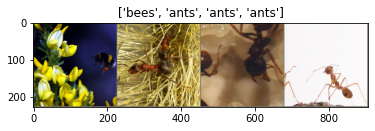

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(trainiter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define a model

In [15]:
def get_model(num_layers, dropout_ratio, num_classes):
    """
    Creates a convolution net using ResNet50 trunk and
    a custom head.
    """
    
    # Get the number of input features to the default head
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    
    # Freeze trunk weights
    for param in model.parameters():
        param.requires_grad = False
    
    # Define a new head
    head = nn.Sequential(nn.Linear(num_features, num_layers),
                         nn.ReLU(),
                         nn.Dropout(dropout_ratio),
                         nn.Linear(num_layers, num_classes))
    
    # Replace the head
    model.fc = head
    
    return model
    

In [16]:
num_layers = 64
dropout_ratio = 0.5
num_classes = 2

model = get_model(num_layers, dropout_ratio, num_classes)


## Inspect the model

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,639,298 total parameters.
131,266 training parameters.


## Define a training loop

In [20]:
from torch.utils.tensorboard import SummaryWriter

def train_model(device, dataloaders, dataset_sizes, model, criterion, 
                optimizer, scheduler, num_epochs=25, log_dir='/tmp'):
    
    since = time.time()
    writer = SummaryWriter(log_dir)
    
    
    

    model = model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Write loss and accuracy to TensorBoard
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Acc/{phase}', epoch_acc, epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Start training

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


data_dir = '/tmp/data/hymenoptera_data'
batch_size = 32
log_dir = 'gs://jk-tensorboards/experiments/102'
num_epochs = 50


In [22]:
dataloaders, datasizes, class_names = get_dataloaders(data_dir, batch_size)

model = train_model(device, dataloaders, datasizes, model, criterion, 
                    optimizer_ft, exp_lr_scheduler, num_epochs, log_dir)

Epoch 0/49
----------
train Loss: 0.7013 Acc: 0.5000
val Loss: 0.6636 Acc: 0.5882

Epoch 1/49
----------
train Loss: 0.6667 Acc: 0.6025
val Loss: 0.6277 Acc: 0.8497

Epoch 2/49
----------
train Loss: 0.6387 Acc: 0.6926
val Loss: 0.5806 Acc: 0.9216

Epoch 3/49
----------
train Loss: 0.5861 Acc: 0.7746
val Loss: 0.5298 Acc: 0.8954

Epoch 4/49
----------
train Loss: 0.5408 Acc: 0.8361
val Loss: 0.4832 Acc: 0.9412

Epoch 5/49
----------
train Loss: 0.5221 Acc: 0.8197
val Loss: 0.4259 Acc: 0.9477

Epoch 6/49
----------
train Loss: 0.4628 Acc: 0.8607
val Loss: 0.3887 Acc: 0.9608

Epoch 7/49
----------
train Loss: 0.4293 Acc: 0.9098
val Loss: 0.3884 Acc: 0.9542

Epoch 8/49
----------
train Loss: 0.4228 Acc: 0.8975
val Loss: 0.3783 Acc: 0.9542

Epoch 9/49
----------
train Loss: 0.4132 Acc: 0.8934
val Loss: 0.3740 Acc: 0.9542

Epoch 10/49
----------
train Loss: 0.4338 Acc: 0.8566
val Loss: 0.3664 Acc: 0.9542

Epoch 11/49
----------
train Loss: 0.4110 Acc: 0.8811
val Loss: 0.3635 Acc: 0.9477

Ep

## TensorBoard setup

In [ ]:
from torch.utils.tensorboard import SummaryWriter


log_dir = 'gs://jk-tensorboards/experiments/1'

writer = SummaryWriter(log_dir)

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)


In [ ]:
writer.add_graph(net, images)
writer.close()

In [ ]:
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [ ]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)